<a href="https://colab.research.google.com/github/Adetayo047/NLP-Research/blob/main/Phillips_Engagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/Mrs Iyanu Project (1)

/content/drive/MyDrive/Mrs Iyanu Project (1)


In [6]:
ls

AllState1.xlsx   Ebonyi/          Ondo/             Taraba/
AllState.xlsx    Ebonyicomb.xlsx  Ondocomb.xlsx     Tarabacomb.xlsx
Bauchi/          Edo/             Plateau/
Bauchicomb.xlsx  Edocomb.xlsx     Plateaucomb.xlsx


In [7]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

data = pd.read_excel('AllState1.xlsx')

In [8]:
data

,State,LGA,Date,Year,Week,variable,LasserFeverValue,Temperature,Precipitation,Relative Humidity
0,Bauchi,Alkaleri,2012-01-02,2012,1,Confirmed,0.0,0.000000,0.0,0.000000
1,Bauchi,Alkaleri,2012-01-09,2012,2,Confirmed,0.0,0.000000,0.0,0.000000
2,Bauchi,Alkaleri,2012-01-16,2012,3,Confirmed,0.0,0.000000,0.0,0.000000
3,Bauchi,Alkaleri,2012-01-23,2012,4,Confirmed,0.0,0.000000,0.0,0.000000
4,Bauchi,Alkaleri,2012-01-30,2012,5,Confirmed,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
18136,Taraba,Karim-Lamido,2020-11-30,2020,48,Confirmed,0.0,299.871429,0.0,17.264286
18137,Taraba,Karim-Lamido,2020-12-07,2020,49,Confirmed,0.0,301.728571,0.0,18.271429
18138,Taraba,Karim-Lamido,2020-12-14,2020,50,Confirmed,0.0,298.014286,0.0,18.571429
18139,Taraba,Karim-Lamido,2020-12-21,2020,51,Confirmed,0.0,297.057143,0.0,20.435714


In [9]:
data.isna().sum()

State                0
LGA                  0
Date                 0
Year                 0
Week                 0
variable             0
LasserFeverValue     0
Temperature          0
Precipitation        0
Relative Humidity    0
dtype: int64

In [10]:
#df.fillna(0, inplace=True)
data.drop(['LGA', 'Year', 'Week', 'variable'], axis=1, inplace=True)

In [11]:
data

,State,Date,LasserFeverValue,Temperature,Precipitation,Relative Humidity
0,Bauchi,2012-01-02,0.0,0.000000,0.0,0.000000
1,Bauchi,2012-01-09,0.0,0.000000,0.0,0.000000
2,Bauchi,2012-01-16,0.0,0.000000,0.0,0.000000
3,Bauchi,2012-01-23,0.0,0.000000,0.0,0.000000
4,Bauchi,2012-01-30,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...
18136,Taraba,2020-11-30,0.0,299.871429,0.0,17.264286
18137,Taraba,2020-12-07,0.0,301.728571,0.0,18.271429
18138,Taraba,2020-12-14,0.0,298.014286,0.0,18.571429
18139,Taraba,2020-12-21,0.0,297.057143,0.0,20.435714


In [ ]:
#df['TimeStamp'] = df['Date'].apply(lambda x: x.timestamp())

In [12]:
#data['Date'] = data['Date'].timestamp()
data ['Date'] = data['Date'].apply(lambda x: x.timestamp())


In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['LasserFeverValue']).iloc[0:size]
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['LasserFeverValue']).iloc[size:]
    y_train=data['LasserFeverValue'].iloc[0:size]
    y_test=data['LasserFeverValue'].iloc[size:]
    return x_train, x_test,y_train,y_test
# unique countries
State=list(set(data.State))
# loop each country_Region and split the data into train and test data
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(State)):
    df= data[data['State'] == State[i]]
    #data[['State']==State[i]]
    # applied the function I created above
    x_train, x_test,y_train,y_test=train_test_split(df)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)
# concatenate each train data n X_train list and Y_train list respectively
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [15]:
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)

    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values

    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    return x_train,x_test,y_train,y_test

In [16]:
encoder = LabelEncoder()
#combine X train and Y train as train data
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['State']= encoder.fit_transform(train_data['State'])
#combine X test and Y test as test data
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['State']= encoder.fit_transform(test_data['State'])
# using the function to obtian reshaped data
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)
#take a look at the reshaped data!
x_train

array([[[5.00000000e+00, 1.32546240e+09, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[5.00000000e+00, 1.32606720e+09, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[5.00000000e+00, 1.32667200e+09, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       ...,

       [[3.00000000e+00, 1.48150080e+09, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[3.00000000e+00, 1.48210560e+09, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[3.00000000e+00, 1.48271040e+09, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.34642857e+01]]])

In [17]:
x_train[:10]

array([[[5.0000000e+00, 1.3254624e+09, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 5.0000000e+00, 1.3260672e+09,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[5.0000000e+00, 1.3260672e+09, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 5.0000000e+00, 1.3266720e+09,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[5.0000000e+00, 1.3266720e+09, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 5.0000000e+00, 1.3272768e+09,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[5.0000000e+00, 1.3272768e+09, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 5.0000000e+00, 1.3278816e+09,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[5.0000000e+00, 1.3278816e+09, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 4.0000000e+00, 5.0000000e+00, 1.3284864e+09,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[5.0000000e+00, 1

In [ ]:
#from pandas import Timestamp
#data['Date'].iloc[0].timestamp()

In [20]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout, BatchNormalization
"""
# design network for confirmed cases data
model = Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(GRU(60, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=30, batch_size=50,  verbose=1, shuffle=False)
"""
model = Sequential()
model.add(LSTM(34, return_sequences = True, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(GRU(17, return_sequences = True, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(SimpleRNN(units=8, activation='relu'))
model.add(Dense(1))
model.compile(loss=['mae', 'mse'], optimizer='adam')
history = model.fit(x_train, y_train, epochs=30, batch_size=16,  verbose=1, shuffle=False)

Epoch 1/30
907/907 [==============================] - 9s 5ms/step - loss: 0.2844
Epoch 2/30
907/907 [==============================] - 4s 5ms/step - loss: 0.1214
Epoch 3/30
907/907 [==============================] - 5s 5ms/step - loss: 0.1207
Epoch 4/30
907/907 [==============================] - 5s 6ms/step - loss: 0.1207
Epoch 5/30
907/907 [==============================] - 4s 4ms/step - loss: 0.1207
Epoch 6/30
907/907 [==============================] - 4s 4ms/step - loss: 0.1207
Epoch 7/30
907/907 [==============================] - 5s 5ms/step - loss: 0.1206
Epoch 8/30
907/907 [==============================] - 4s 5ms/step - loss: 0.1206
Epoch 9/30
907/907 [==============================] - 4s 5ms/step - loss: 0.1206
Epoch 10/30
907/907 [==============================] - 6s 6ms/step - loss: 0.1207
Epoch 11/30
907/907 [==============================] - 5s 5ms/step - loss: 0.1206
Epoch 12/30
907/907 [==============================] - 4s 5ms/step - loss: 0.1206
Epoch 13/30
907/907 [====

114/114 [==============================] - 1s 4ms/step


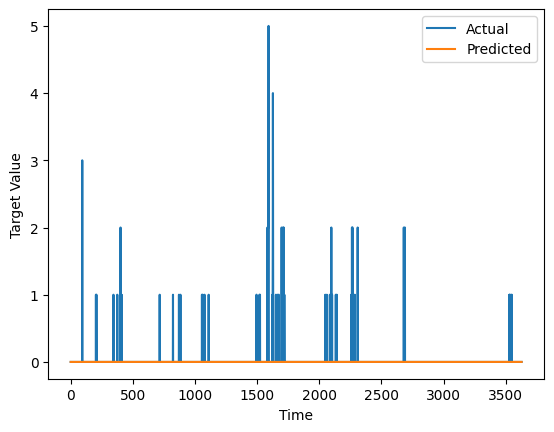

In [21]:
import matplotlib.pyplot as plt

# Assuming 'target_column' is the actual target column in the dataframe
plt.plot(y_test, label='Actual')
plt.plot(model.predict(x_test), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.show()
